# RestNet Implementation

This example implements a ResNet network by implementing both ResNet identity- and convolution blocks. The network is then used for classifying blood cell types. Original images are from https://www.kaggle.com/paultimothymooney/blood-cells. Training uses two callbacks, which are:

* **EarlyStopping**. This callback stops training when a monitored metric has stopped improving.
* **ModelCheckpoint**. This callback saves the weights based on some criteria, like best model based on validation loss.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Reduce TF verbosity
import tensorflow as tf
tf.get_logger().setLevel('INFO') # Reduce TF verbosity
print(f"tensorflow version: {tf.__version__}")

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import os
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, \
  BatchNormalization, ZeroPadding2D, MaxPooling2D, Activation, add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from tensorflow.keras.optimizers import Adam

from glob import glob
import gdown
import zipfile
import utils

tensorflow version: 2.6.0


In [2]:
def download_blood_cells_data():
    url = 'https://drive.google.com/file/d/15_VKmPuwkHye_8z8MdBx7EbwrS_Wdhog/view?usp=sharing'
    output = './large_files/blood_cells.zip'
    if not os.path.exists('./large_files/blood_cells'):
        gdown.download(url, output, quiet=False, fuzzy=True)
        with zipfile.ZipFile('./large_files/blood_cells.zip', 'r') as zip_ref:
            zip_ref.extractall('./large_files')

In [3]:
# Download blood cells data
download_blood_cells_data()

In [4]:
src_path_training = os.path.join(os.path.realpath('.'), 'large_files', 'blood_cells', 'TRAIN')
src_path_test = os.path.join(os.path.realpath('.'), 'large_files', 'blood_cells', 'TEST')

image_size = [100, 100]

training_images = glob(src_path_training + '/*/*.jp*g')
test_images = glob(src_path_test + '/*/*.jp*g')
folders = glob(src_path_training + '/*')

print(f'Number of training images: {len(training_images)}')
print(f'Number of testing images: {len(test_images)}')
print(f'Number of classes: {len(folders)}')

Number of training images: 9957
Number of testing images: 2487
Number of classes: 4


In [5]:
def resnet_identity_block(input_, kernel_size, filters):
    '''
    ResNet identity block. Skip connection can be thought of being
    an identity function meaning that the signal stays the same, i.e. f(x) = x
    '''
    
    f1, f2, f3 = filters
    
    # 1x1 convolution with f1 number of filters
    # We end up with m*n*f1 feature map/image
    x = Conv2D(f1, (1, 1), kernel_initializer='he_normal')(input_)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(f2, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(f3, (1, 1), kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = add([x, input_])
    x = Activation('relu')(x)
    
    return x

In [6]:
def resnet_conv_block(input_, kernel_size, filters, strides=(2, 2)):
    '''
    Resnet convolution block. Convolution is applied to the skip connection branch,
    before adding it to the normal branch.
    '''
    f1, f2, f3 = filters
    
    # 1x1 convolution with f1 number of filters
    # We end up with m*n*f1 feature map/image
    x = Conv2D(f1, (1, 1), kernel_initializer='he_normal')(input_)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(f2, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(f3, (1, 1), kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    # Skip connection with convolution
    x_ = Conv2D(f3, (1, 1), strides=strides, kernel_initializer='he_normal')(x)
    x_ = BatchNormalization()(x_)
    
    x = add([x, x_])
    x = Activation('relu')(x)
    
    return x

In [7]:
# Create a ResNet model
i = Input(shape=image_size + [3])
x = ZeroPadding2D(padding=(3, 3))(i)
x = Conv2D(64, (7, 7), strides=(2, 2), padding='valid',
          kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

x = resnet_conv_block(x, 3, [64, 64, 256], strides=(1, 1))
x = resnet_identity_block(x, 3, [64, 64, 256])
x = resnet_identity_block(x, 3, [64, 64, 256])

x = resnet_conv_block(x, 3, [128, 128, 512], strides=(1, 1))
x = resnet_identity_block(x, 3, [128, 128, 512])
x = resnet_identity_block(x, 3, [128, 128, 512])
x = resnet_identity_block(x, 3, [128, 128, 512])

x = Flatten()(x)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(i, prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 50, 50, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 50, 50, 64)   256         conv2d[0][0]                     
______________________________________________________________________________________________

Found 9957 images belonging to 4 classes.
Normalization, mean: [[[172.47687 163.04744 167.59755]]]
Normalization, standard deviation: [[[66.65131  66.59899  65.854385]]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Found 9957 images belonging to 4 classes.
Image classes
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}
Displaing an image from the generator
Image type: <class 'numpy.ndarray'>
Image max value: 1.2306835651397705
Image min value: -2.5877490043640137


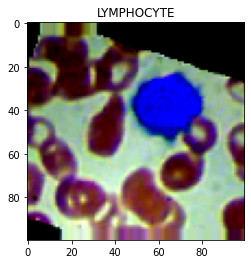

In [8]:
dir_iter = DirectoryIterator(src_path_training, None, target_size=image_size, batch_size=128)
img_batch, class_batch = dir_iter.next()

# Create an image data generator in order to augment the input data
gen = ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization = True,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    #shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True)

# Calculate the statistics
gen.fit(img_batch)
print(f'Normalization, mean: {gen.mean}')
print(f'Normalization, standard deviation: {gen.std}')

test_gen = gen.flow_from_directory(src_path_training, target_size=image_size)

print('Image classes')
print(test_gen.class_indices)

labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

# We expect the image to look 'strange' to the using the preprocessor
print('Displaing an image from the generator')
for x, y in test_gen:
    plt.title(labels[np.argmax(y[0])])
    print(f'Image type: {type(x[0])}')
    print(f'Image max value: {np.max(x[0])}')
    print(f'Image min value: {np.min(x[0])}')
    plt.imshow(x[0])
    plt.show()
    break

In [9]:
epochs = 20
batch_size = 64

print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(),
    metrics = ['accuracy']
)

# Training data generator
training_generator = gen.flow_from_directory(
    src_path_training,
    target_size = image_size,
    shuffle = True,
    batch_size = batch_size)

# Validation data generator
validation_generator = gen.flow_from_directory(
    src_path_test,
    target_size = image_size,
    shuffle = True,
    batch_size = batch_size)

# Train the model with callbacks
# - first callback is for early stopping
# - second callback is for storing the best model
checkpoint_filepath = './large_files/checkpoint'
r = model.fit(
    training_generator,
    validation_data = validation_generator,
    epochs = epochs,
    steps_per_epoch = len(training_images) // batch_size,
    validation_steps = len(test_images) // batch_size,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor = 'loss',
            patience = 3,
            restore_best_weights = True),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only = True,
            monitor = 'val_accuracy',
            mode = 'max',
            save_best_only = True)
    ]
)

Epochs: 20
Batch size: 64
Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.
Epoch 1/20
155/155 [==============================] - 48s 273ms/step - loss: 17.2376 - accuracy: 0.3023 - val_loss: 12.1483 - val_accuracy: 0.2529
Epoch 2/20
155/155 [==============================] - 39s 248ms/step - loss: 2.3085 - accuracy: 0.5262 - val_loss: 1.2473 - val_accuracy: 0.5354
Epoch 3/20
155/155 [==============================] - 37s 236ms/step - loss: 1.5241 - accuracy: 0.6730 - val_loss: 2.7243 - val_accuracy: 0.6908
Epoch 4/20
155/155 [==============================] - 37s 236ms/step - loss: 0.8134 - accuracy: 0.7857 - val_loss: 1.3000 - val_accuracy: 0.5933
Epoch 5/20
155/155 [==============================] - 37s 236ms/step - loss: 0.4498 - accuracy: 0.8502 - val_loss: 0.6442 - val_accuracy: 0.8059
Epoch 6/20
155/155 [==============================] - 39s 249ms/step - loss: 0.3170 - accuracy: 0.8899 - val_loss: 0.4602 - val_accuracy: 0.8507
Epoch 7/20
155/155

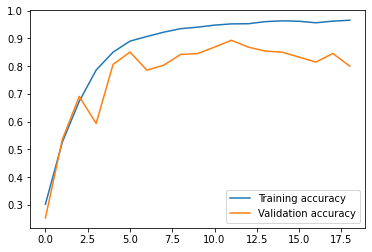

In [10]:
# Plot accuracy
plt.plot(r.history['accuracy'], label='Training accuracy')
plt.plot(r.history['val_accuracy'], label='Validation accuracy')
plt.legend()

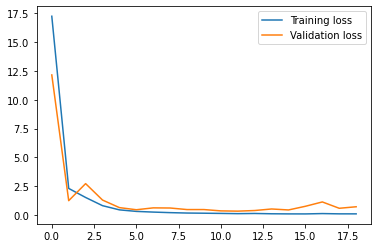

In [11]:
# Plot loss
plt.plot(r.history['loss'], label='Training loss')
plt.plot(r.history['val_loss'], label='Validation loss')
plt.legend()

In [12]:
# Load the best model weights
model.load_weights(checkpoint_filepath)

Creating a confusion matrix
Found 9957 images belonging to 4 classes.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 311/312 [00:50<00:00,  6.13it/s]


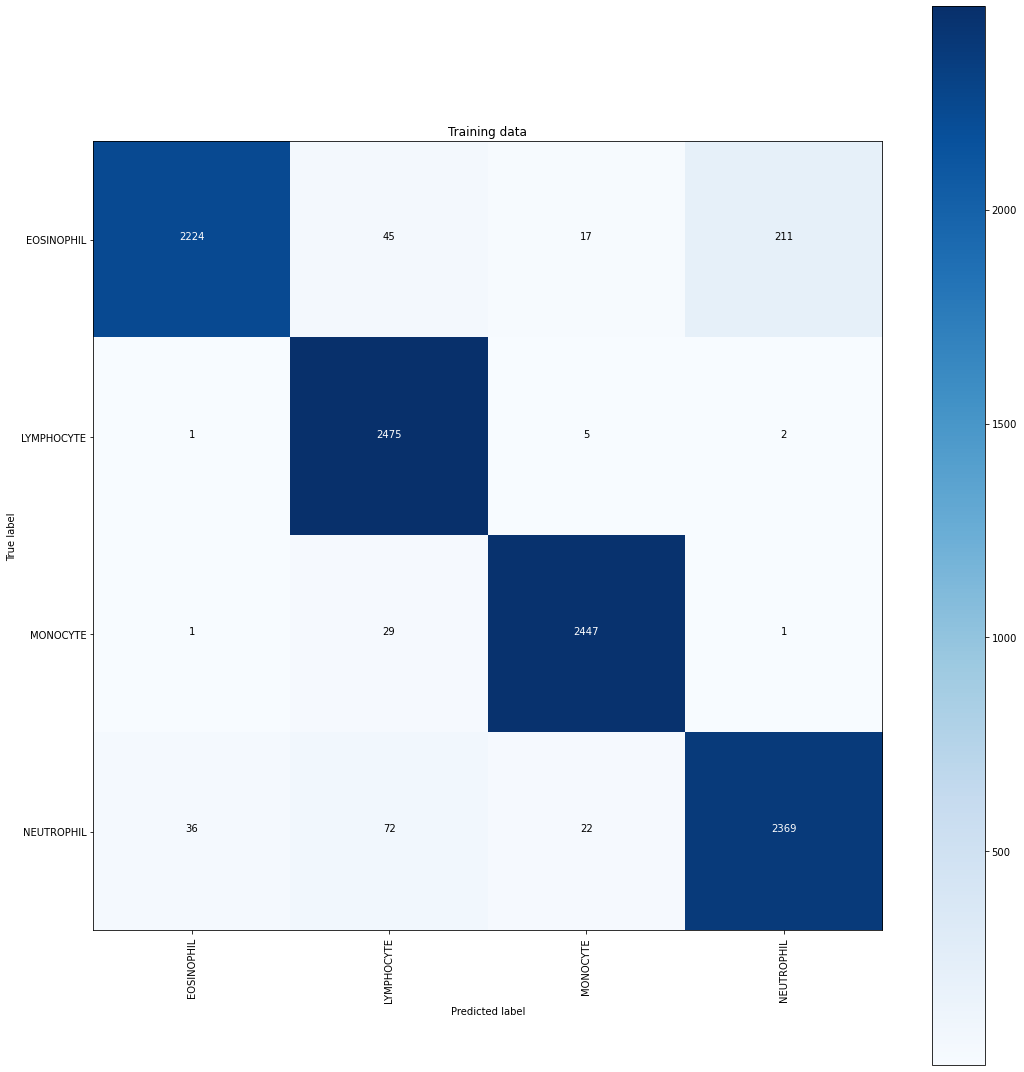

In [13]:
# Create and display confusion matrix for the training data
cm, class_names_training = utils.get_confusion_matrix(model, gen, src_path_training, image_size)
utils.plot_confusion_matrix(cm, class_names_training, 'Training data')

Creating a confusion matrix
Found 2487 images belonging to 4 classes.


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 77/78 [00:12<00:00,  6.04it/s]


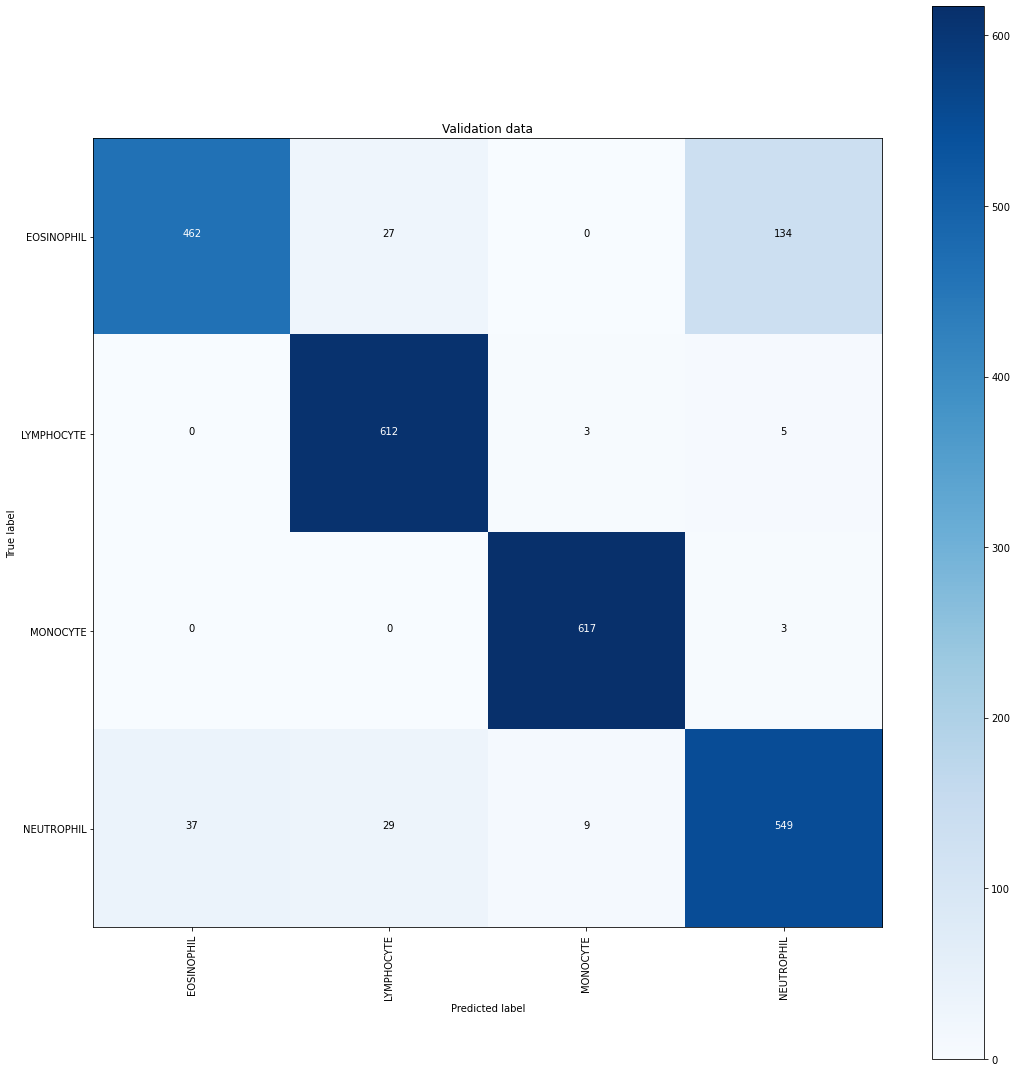

In [14]:
# Create and display confusion matrix for the validation data
validation_cm, class_names_validation = utils.get_confusion_matrix(model, gen, src_path_test, image_size)
utils.plot_confusion_matrix(validation_cm, class_names_validation, 'Validation data')

In [15]:
# Calculate accuracy for training data
print(f'Accuracy for training data: {np.trace(cm) / cm.sum()}')

# Calculate accuracy for validation data
print(f'Accuracy for training data: {np.trace(validation_cm) / validation_cm.sum()}')

Accuracy for training data: 0.9556091192126143
Accuracy for training data: 0.9006835544833133
